In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
data_dir = './data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
# data 전처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

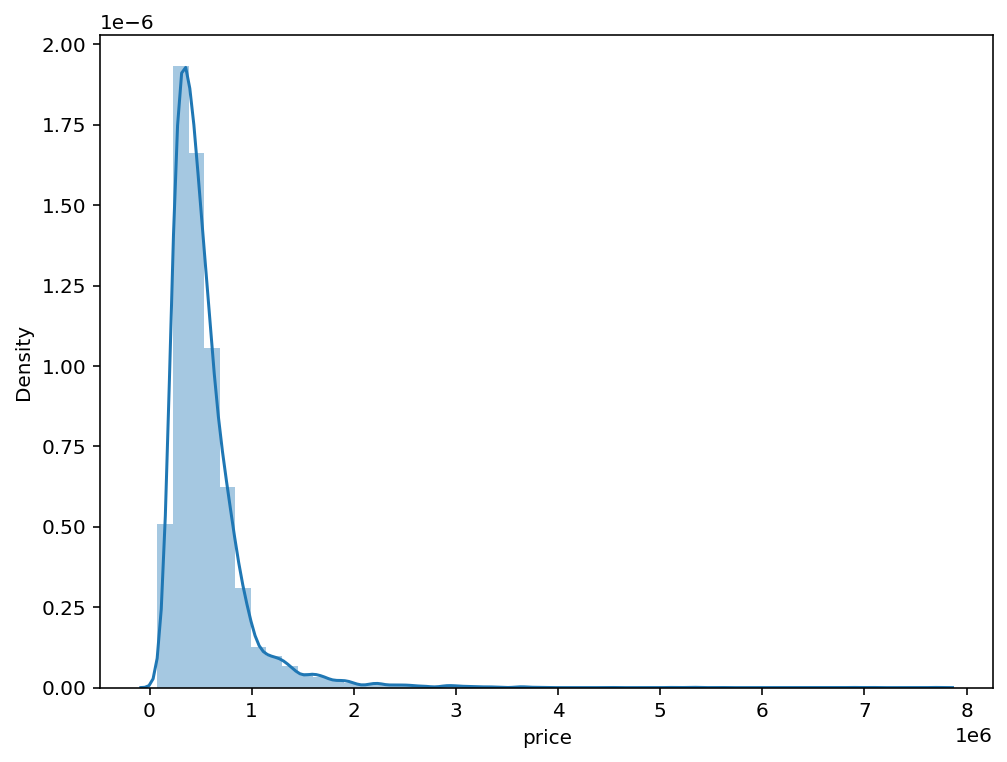

In [5]:

fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

In [6]:
cols = train.columns
cols

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### 전처리

In [7]:
train.isnull().sum()


id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [8]:
# id_duplicated = train[train.duplicated(['id'])]
print(len(train['id']))
print(len(pd.value_counts(train['id'])))

15035
15035


### 목적변수(price) 정규분포

<AxesSubplot:xlabel='price', ylabel='Density'>

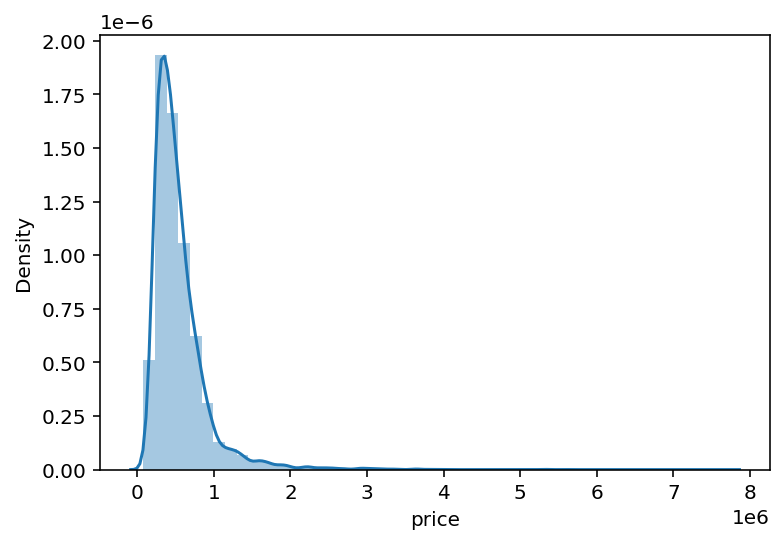

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(train['price'])

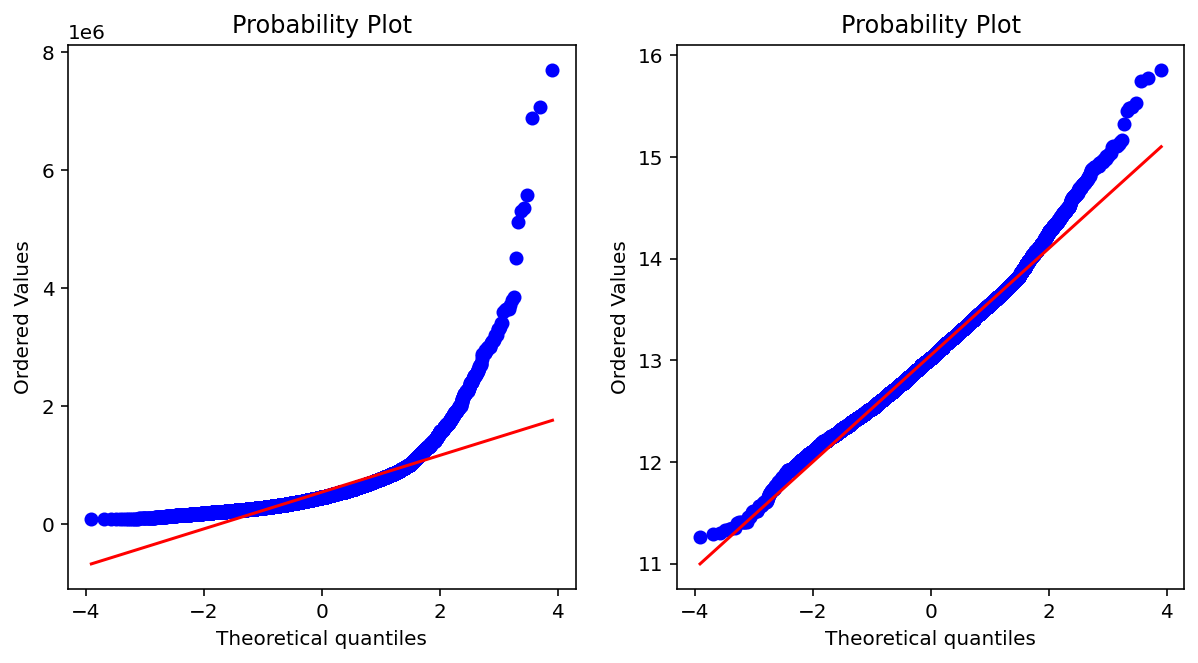

In [10]:

# log를 취해줬을 때 정규성 확인
fig = plt.figure(figsize = (10,5))

fig.add_subplot(1,2,1)
res = sp.stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = sp.stats.probplot(np.log1p(train['price']), plot=plt)

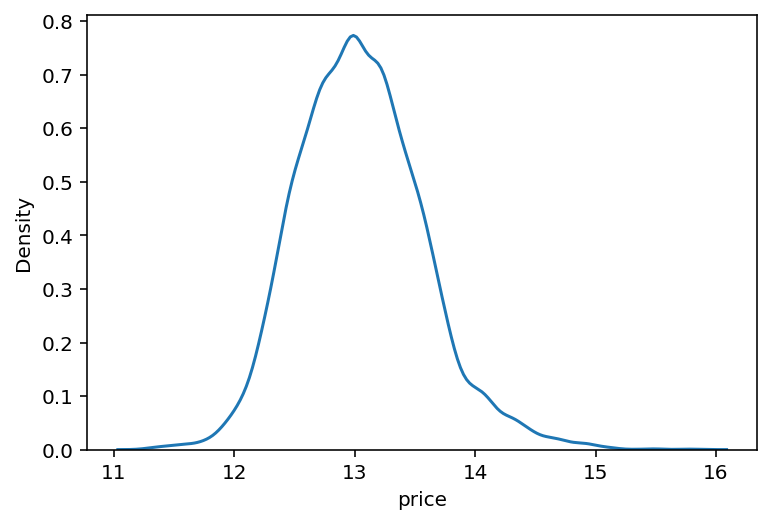

In [11]:

# 목적변수 정규분포
train['price'] = np.log1p(train['price'])
sns.kdeplot(train['price'])
plt.show()

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

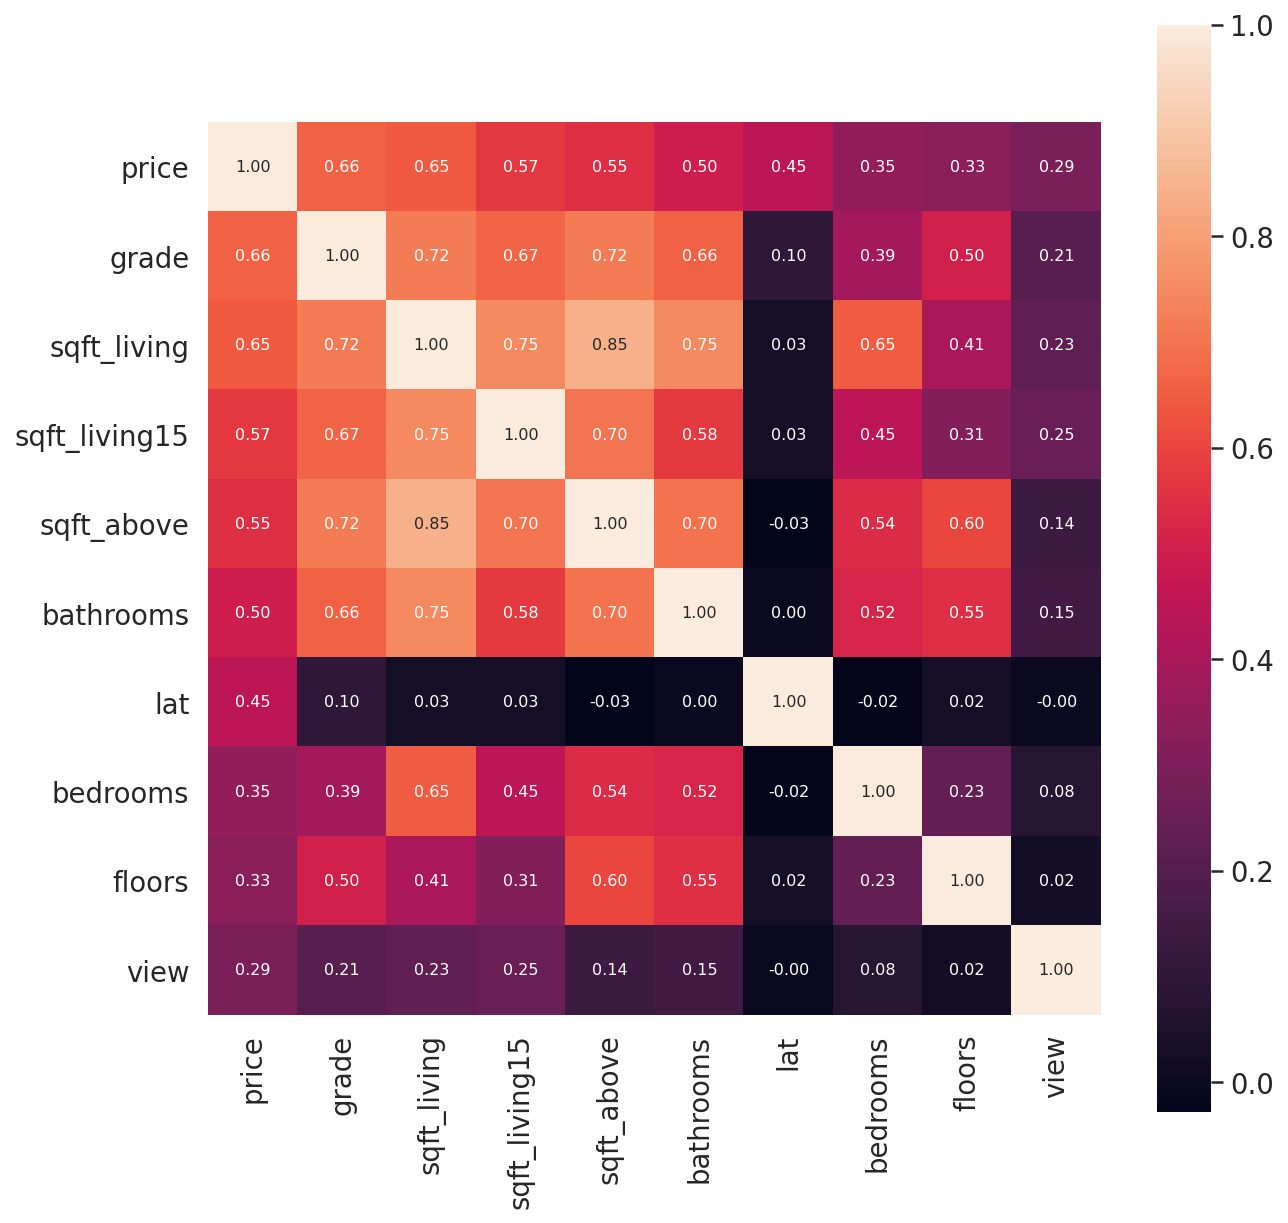

In [12]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

### 이상치 제거 (heatmap 기준)
- price와 상관관계가 많은 grade, sqft_living, sqft_above, bathrooms, sqft_living15 순으로 판단함

In [13]:
train.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,...,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,201438.545993,13.048122,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,...,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,44.252050,0.527471,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,...,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,201405.000000,11.264477,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,201407.000000,12.682310,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,201410.000000,13.017005,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,...,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,201502.000000,13.377007,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,...,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,201505.000000,15.856731,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


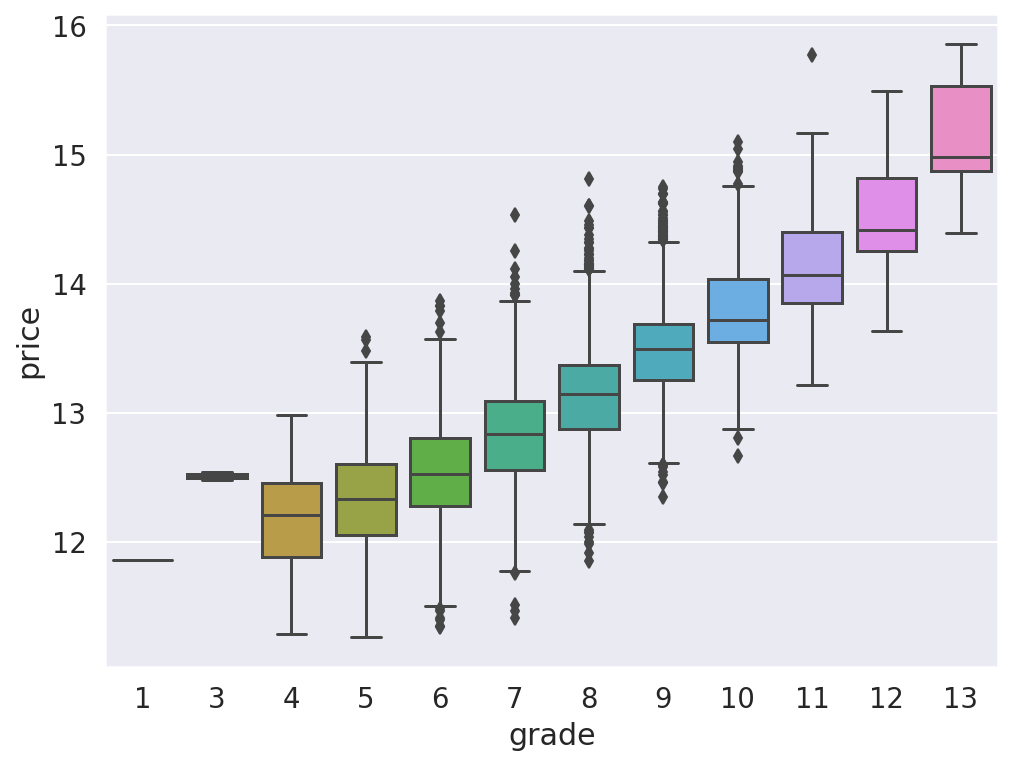

In [14]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data = data)

In [15]:
train.loc[(train['grade'] == 3) & (train['price'] > 12)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [16]:
train.loc[(train['grade'] == 7) & (train['price'] > 14.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,201501,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [17]:
train.loc[(train['grade'] == 8) & (train['price'] > 14.7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [18]:
train.loc[(train['grade'] == 7) & (train['price'] < 11.5)] # ==7 밑에 있는 값


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2372,2372,201412,11.461643,2,1.0,800,8550,1.0,0,0,...,7,800,0,1947,0,98198,47.4075,-122.294,1490,8550
8756,8756,201405,11.407576,2,1.0,790,2640,1.0,0,0,...,7,790,0,1973,0,98034,47.7351,-122.178,1310,2064


In [19]:
train.loc[(train['grade'] == 11) & (train['price'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [20]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 12346]
train = train.loc[train['id'] != 7173]
train = train.loc[train['id'] != 2372]
train = train.loc[train['id'] != 8756]
train = train.loc[train['id'] != 12346]
print(len(train['id']))
# 총 7개

15029


### 이상치 제거
- sqft_living : 주거 공간의 평방 비트(면적)
- 전체적으로 크기가 커지면서 가격이 오르는 것을 볼 수 있다.

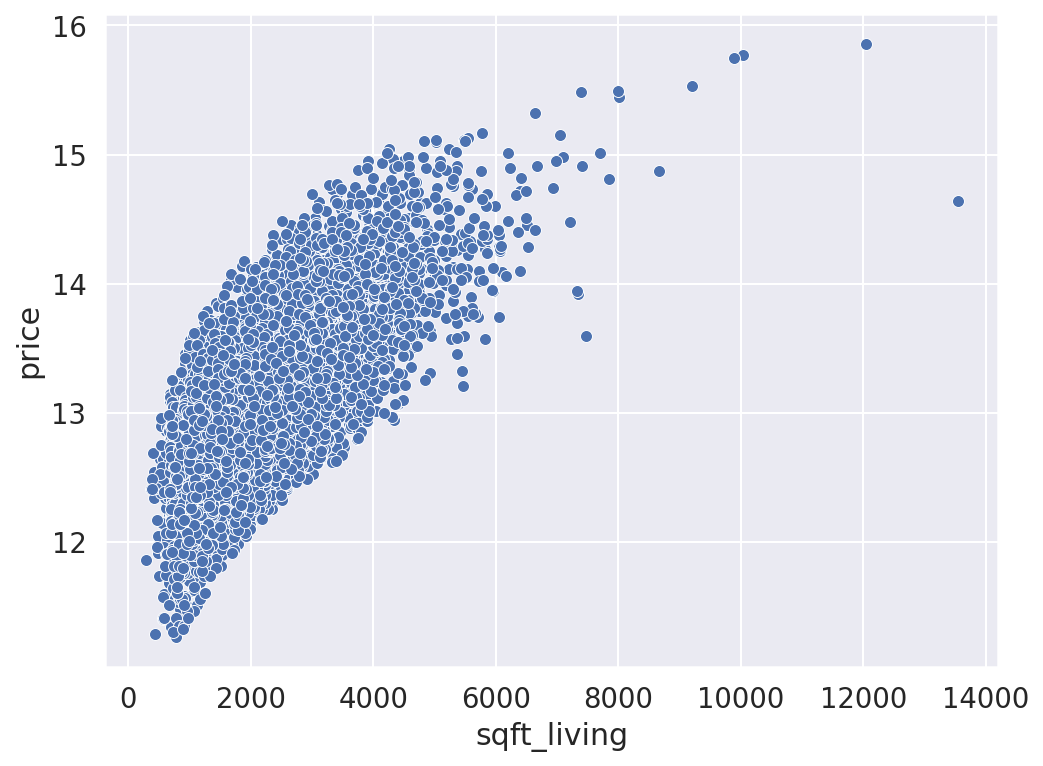

In [21]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living', y='price', data = data)

In [22]:
train.loc[train['sqft_living']>8500]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.770310,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,3134,201408,15.532906,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,5108,201410,15.856731,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,201409,15.744856,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
8912,8912,201405,14.639686,7,8.00,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800
10152,10152,201406,14.876075,5,6.25,8670,64033,2.0,0,4,...,13,6120,2550,1965,2003,98177,47.7295,-122.372,4140,81021


In [23]:
train = train.loc[train['id'] != 2775]
train = train.loc[train['id'] != 3134]
train = train.loc[train['id'] != 5108]
train = train.loc[train['id'] != 6469]
train = train.loc[train['id'] != 8912]
train = train.loc[train['id'] != 10152]
print(len(train['id']))

15023


### 이상치 제거
- sqft_above : 지하실을 제외한 평방 피트(면적)
- 면적이 커질 수록 비싸짐

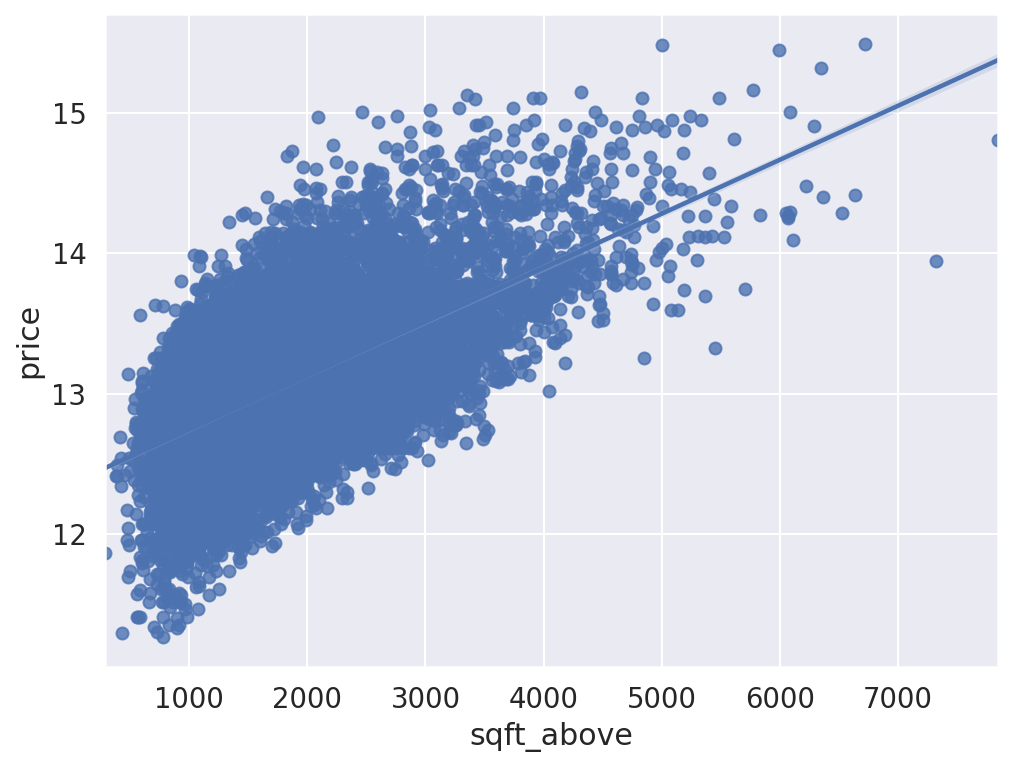

In [24]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y='price', data = data)

In [25]:
train.loc[train['sqft_above']>6500]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1045,1045,201504,15.492607,5,5.0,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
7739,7739,201406,14.414348,4,4.5,6640,53330,2.0,0,0,...,12,6640,0,1993,0,98077,47.7283,-122.046,4620,68625
12921,12921,201407,13.942364,5,4.0,7320,217800,2.0,0,0,...,11,7320,0,1992,0,98058,47.4473,-122.086,3270,34500
13809,13809,201501,14.808763,4,4.0,7850,89651,2.0,0,0,...,12,7850,0,2006,0,98027,47.5406,-121.982,6210,95832
14225,14225,201504,14.285515,4,5.5,6530,871200,2.0,0,2,...,11,6530,0,2008,0,98014,47.6640,-121.878,1280,858132


In [26]:
train = train.loc[train['id'] != 1045]
train = train.loc[train['id'] != 7739]
train = train.loc[train['id'] != 12921]
train = train.loc[train['id'] != 13809]
train = train.loc[train['id'] != 14225]

print(len(train['id']))

15018


#### bathrooms
- bathrooms : 화장실의 수
- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

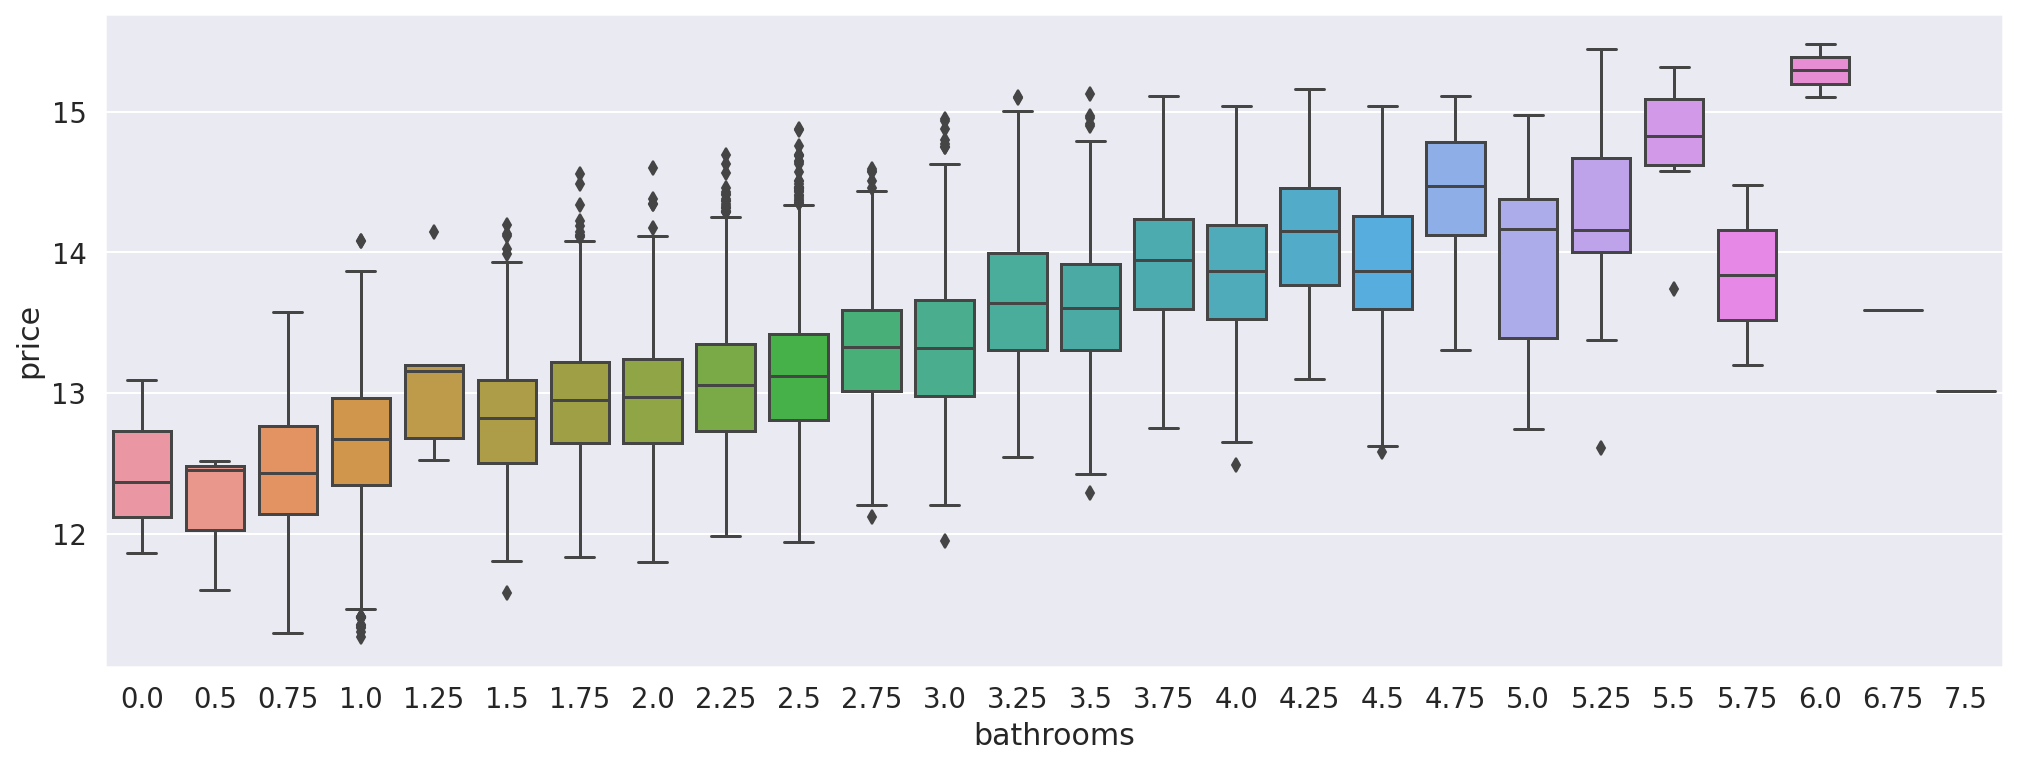

In [27]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(17, 6))
fig = sns.boxplot(x='bathrooms', y='price', data = data)

In [28]:
train.loc[(train['bathrooms'] == 1.25) & (train['price'] > 14)]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12969,12969,201411,14.143375,3,1.25,2400,6653,3.0,0,2,...,11,2400,0,1992,0,98122,47.6019,-122.29,1910,6653


In [29]:
train.loc[(train['bathrooms'] == 5.25) & (train['price'] < 13)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11701,11701,201405,12.611541,6,5.25,2860,5682,2.0,0,0,...,7,2860,0,1978,0,98002,47.303,-122.221,1390,5956


In [30]:
train.loc[(train['bathrooms'] == 5.5) & (train['price'] < 14)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9686,9686,201407,13.73755,5,5.5,5190,12637,2.0,0,2,...,11,5190,0,2001,0,98065,47.5424,-121.872,3840,12637


In [31]:
train = train.loc[train['id'] != 12969]
train = train.loc[train['id'] != 11701]
train = train.loc[train['id'] != 9686]

print(len(train['id']))

15015


In [32]:
train.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,1.501500e+04,15015.000000,15015.000000,15015.000000,...,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000
mean,7516.508691,201438.555511,13.046649,3.367965,2.112204,2078.527206,1.519213e+04,1.497536,0.006926,0.232234,...,7.657809,1789.770097,288.757110,1971.098635,83.248485,98078.053080,47.560691,-122.213784,1991.261272,12735.517816
std,4340.539680,44.255397,0.523966,0.900764,0.759071,900.441561,4.195574e+04,0.538291,0.082939,0.759260,...,1.172365,816.649976,437.569896,29.403541,399.145774,53.292826,0.138159,0.141224,688.564879,26810.376273
min,0.000000,201405.000000,11.264477,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,201407.000000,12.682310,3.000000,1.750000,1430.000000,5.026500e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472600,-122.328000,1490.000000,5100.000000
50%,7516.000000,201410.000000,13.017005,3.000000,2.250000,1910.000000,7.615000e+03,1.500000,0.000000,0.000000,...,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1850.000000,7602.000000
75%,11274.500000,201502.000000,13.377007,4.000000,2.500000,2560.000000,1.066000e+04,2.000000,0.000000,0.000000,...,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10060.000000
max,15034.000000,201505.000000,15.483218,10.000000,7.500000,8010.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,6370.000000,3260.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6110.000000,871200.000000


In [33]:
len(train.columns)

21

### 전처리 과정 전 과 후 비교
- price 값에 25%, 50%, 75% 값은 변함이 없다. (이상치 값들을 제거 했는데 왜 변함이 없을까?)
- 다행히도 max 값은 미세하게 변한것으로 보아 price에 max값에 해당하는 이상치 값을 줄였다.
- 스크린샷 2021-08-02 오후 9.56.06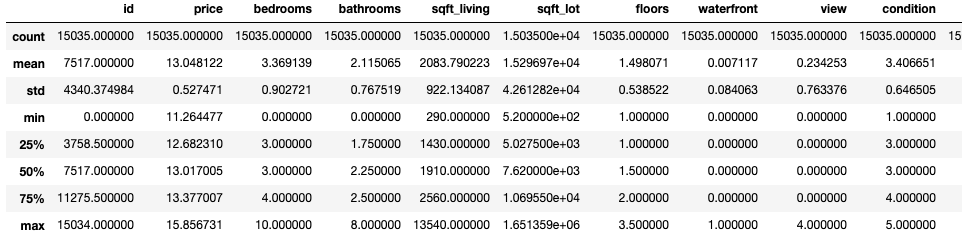 # 후

### 왜 living15를 써야 할까?
- 출처(https://github.com/ceuity/AIFFEL/blob/main/exploration_09/%5BE-09%5Dkaggle_kakr_housing.ipynb)
- living_15를 통해서 2015년 재건축 해당하는 변수를 이용해야 하는 점을 파악함 (yr_renovated의 max값이 2015년을 고려)


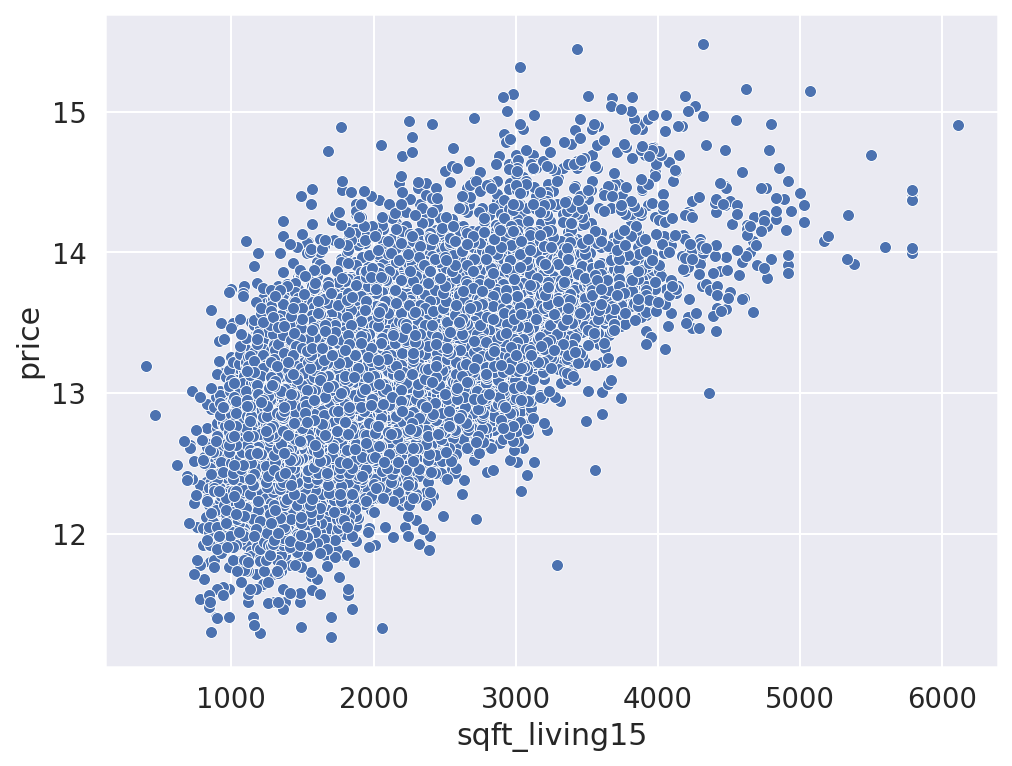

In [34]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living15', y='price', data = data)

In [35]:
z = train['sqft_living15']

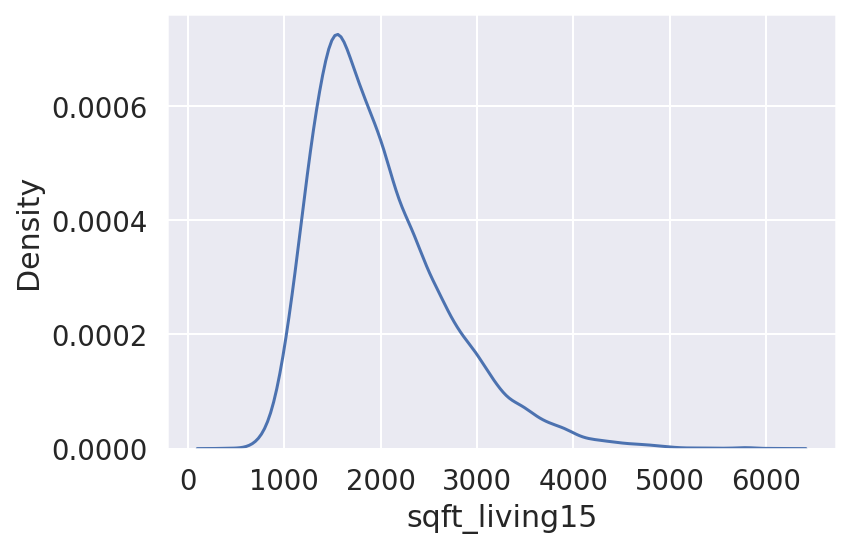

In [36]:
sns.kdeplot(z)
plt.show()

In [37]:
z = np.log1p(z)


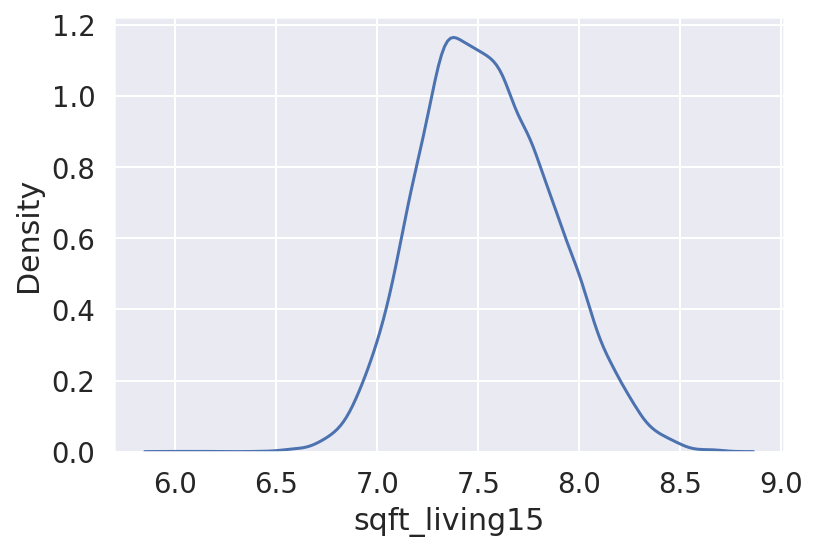

In [38]:
sns.kdeplot(z)
plt.show()

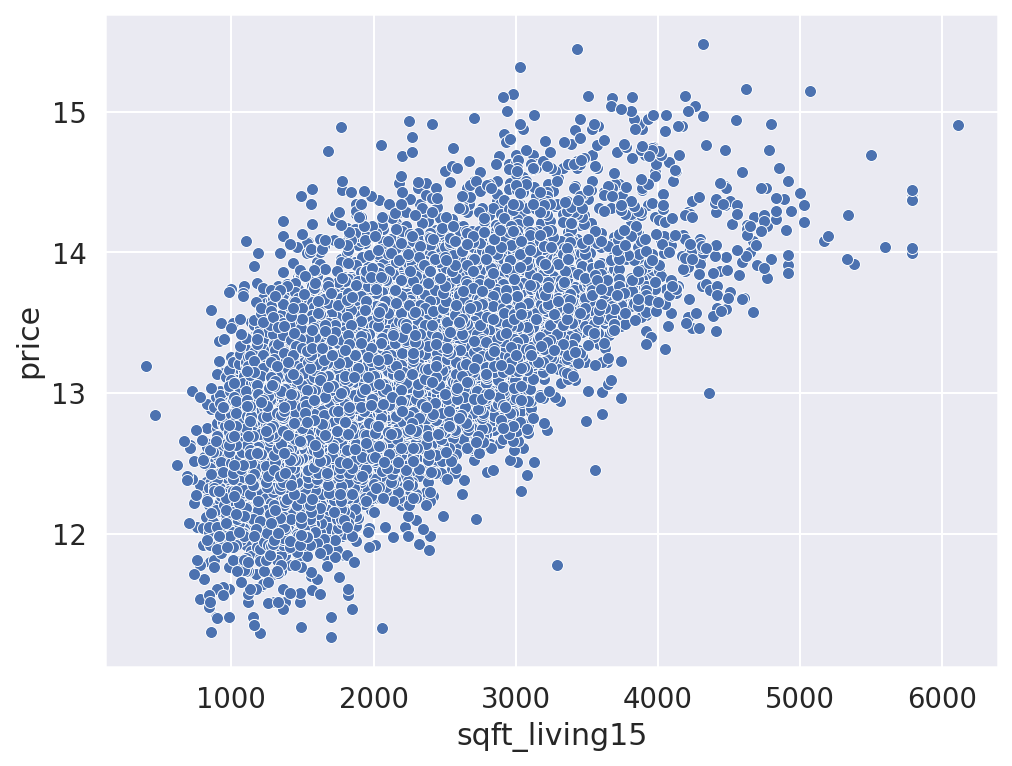

In [39]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x='sqft_living15', y='price', data = data)

### living15를 log변환을 통해 정규화를 시켜 보았지만 큰 변화가 보이지 않음

### 먼저 정규화 부터

In [40]:
# 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values) # 각 요소에 대해 자연로그 log(1 + x)를 반환
    test[c] = np.log1p(test[c].values)

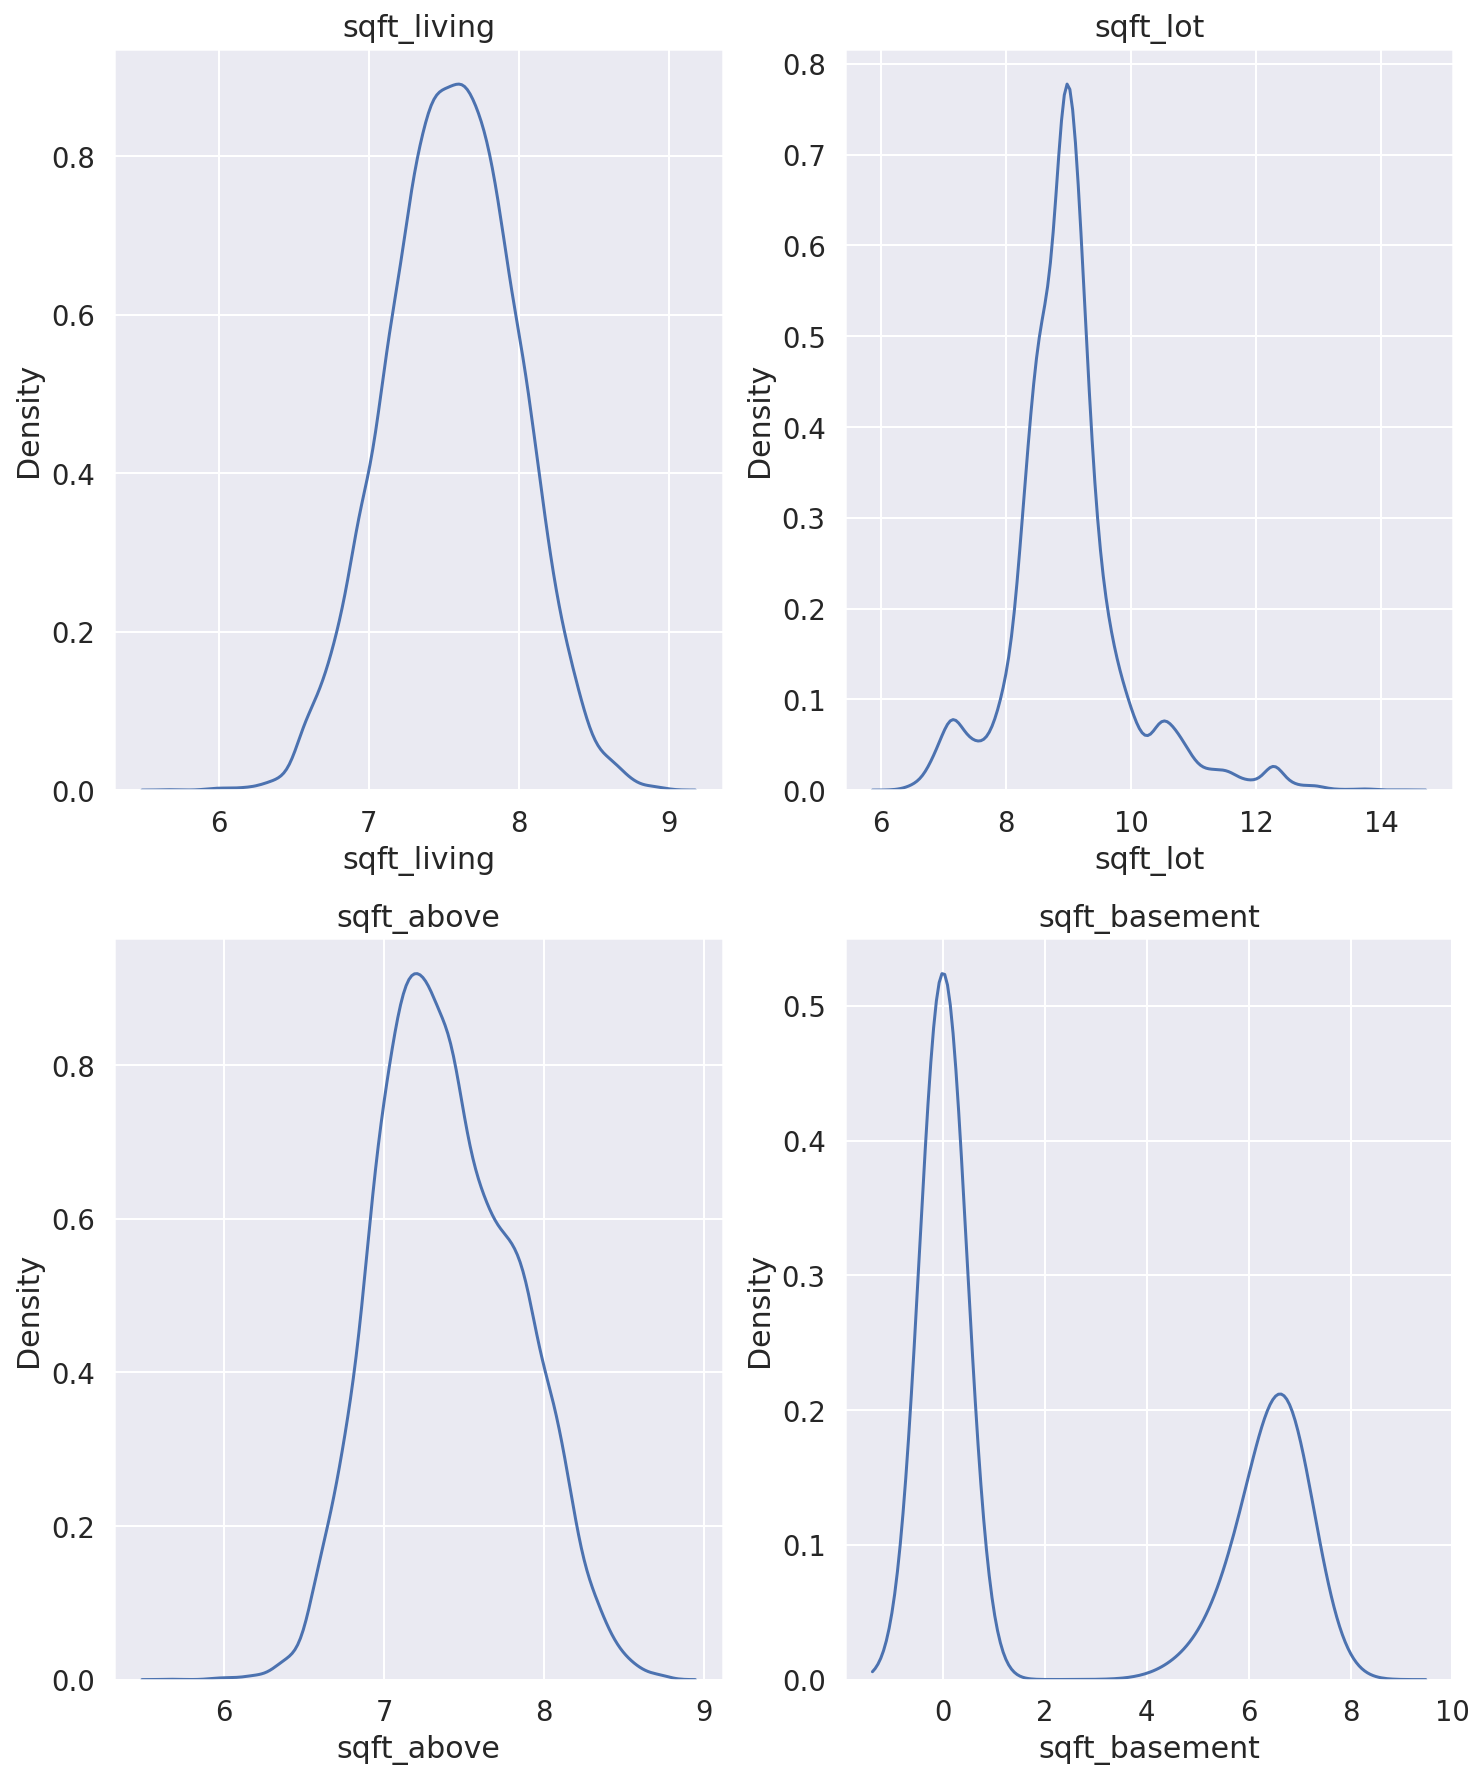

In [41]:
# 변환 후 분포 확인
fig, ax = plt.subplots(2, 2, figsize=(12, 15))

count = 0
for row in range(2):
    for col in range(2):
        if count == 4:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### 우리는 일전에 train 데이터를 통해서 이상치 값을 줄였다.
- 이후 train,test 변수들을 종합해서 price와 변수들간의 상관관계를 알아보자
- 결과는 heatmap에 grade 0.66 에서 0.72가 나온것을 보니 linving15의 변수가 존재하는 이유와 데이터 전처리 과정의 중요성을 알게 되었다.

In [42]:
# 변수 수정
for df in [train, test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [43]:
# 변수 생성
for df in [train, test]:
    # 방의 전체 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms'] # 침실의 수 + 침실당 화장실의 개수
    
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot'] # 부지의 평방 피트 / 부지의 평방 피트
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] # 지하실을 제외한 평방 피트 + 지하실의 평방 피트
    
    # 면적 대비 거실의 비율
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size'] # 주거 공간의 평방 피트 / 거실의 비율
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] # 2015년 주거 공간의 평방 피트 / 2015년 기준 부지의 평방 피트
    
    # 재건축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']  # 집을 재건축한 년도 - 집을 지은 년도
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1) # 재건축을 하지 않은 집도 있음

In [44]:
# sqft당 가격 정보 변수 생성
train['per_price'] = train['price'] / train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')   # on 옵션을 통해 기준을 정할 수 있다.

In [45]:
# zipcode에 따른 가격정보인 zip_level 변수 생성
a = train[['zipcode', 'price']].groupby('zipcode').mean() # mean() 평균을 구한다.
label = [j+1 for j in range(27)]
a['zip_level'] = pd.cut(a.price, bins=27, labels=label)
a = a.drop(['price'], axis=1)   # drop() 함수는 행이나 열에서 지정된 레이블을 삭제하는 데 사용됩니다.

train = train.merge(a, on='zipcode', how='left')
test = test.merge(a, on='zipcode', how='left')  # train 과 test를 데이터를 결합
train.zip_level = train.zip_level.astype(int) # 누락된 값 처리
test.zip_level = test.zip_level.astype(int)

0.7281098614210809


<AxesSubplot:xlabel='zip_level', ylabel='price'>

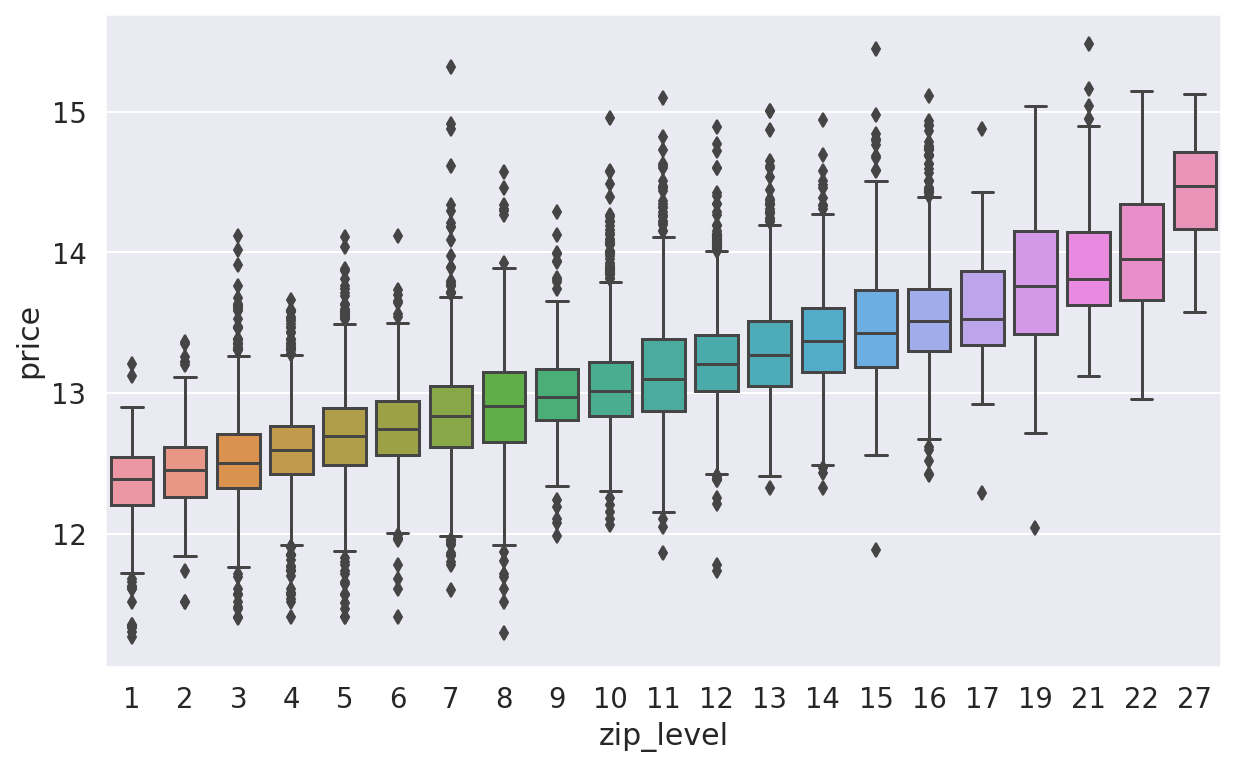

In [46]:
print(train.price.corr(train.zip_level)) # 열 사이의 상관 관계를 찾을 수 있습니다.
fig = plt.figure(figsize=(10, 6))
sns.boxplot(train.zip_level, train.price)

In [76]:
train.describe()
### total_rooms,  sqft_ratio,sqft_total_size,  sqft_ratio_1,  sqft_ratio15,  is_renovated,  per_price,mean,  var,  zip_level
### 9개의 변수가 더 생김

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zip_level,mean_price,new_grade,zipcode_mean,zipcode_var
count,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,...,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000,15015.000000
mean,201438.555511,3.367965,2.112204,7.551313,8.990986,1.497536,0.006926,0.232234,3.406993,7.657809,...,0.846450,9.917859,0.827663,0.307985,0.041692,9.678988,13.046649,11.297036,14.123827,1.382262
std,44.255397,0.900764,0.759071,0.423331,0.903677,0.538291,0.082939,0.759260,0.646530,1.172365,...,0.079610,3.110220,0.214917,0.224935,0.199890,4.870350,0.439111,1.621777,4.209608,0.620217
min,201405.000000,0.000000,0.000000,5.673323,6.255750,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.485142,5.673323,0.542840,0.001449,0.000000,1.000000,11.881825,2.000000,7.679645,0.296675
25%,201407.000000,3.000000,1.750000,7.266129,8.522678,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.798839,7.359468,0.559016,0.173858,0.000000,5.000000,12.709892,10.000000,10.643809,0.929569
50%,201410.000000,3.000000,2.250000,7.555382,8.938007,1.500000,0.000000,0.000000,3.000000,7.000000,...,0.844409,7.908755,1.000000,0.247036,0.000000,10.000000,13.044551,11.000000,12.068981,1.197885
75%,201502.000000,4.000000,2.500000,7.848153,9.274348,2.000000,0.000000,0.000000,4.000000,8.000000,...,0.896342,13.467634,1.000000,0.379317,0.000000,13.000000,13.321262,12.000000,18.406666,2.031464
max,201505.000000,10.000000,7.500000,8.988571,14.317110,3.500000,1.000000,4.000000,5.000000,13.000000,...,1.245564,16.329762,1.000000,2.241814,1.000000,27.000000,14.517023,21.000000,25.991591,2.832655


## 우리는 zip_level을 통해서 price와 각 레벨의 상관관계를 알아보았다.
-  이후 kmeans를 이용해서 변수들을 더 price와 관계를 더 
-  가장 가까운 평균 (클러스터 중심 또는 클러스터 중심 )을 갖는 클러스터에 속하는 k 클러스터로 n개의 관측치를 분할 하는 것을 목표


In [47]:
# zip_mean_price를 Kmeans로 분류한 변수 생성
train['coord_cluster'] = None
test['coord_cluster'] = None

for i in train.zipcode.unique():  # unique() 함수는 배열의 고유한 요소를 찾는 데 사용됩니다 . 배열의 정렬된 고유 요소를 반환
    df = train.loc[train.zipcode == i]
    coord = df[['lat','long']]
    num = (np.ceil(len(df) / 15)).astype(int)
    kmeans = KMeans(n_clusters=num, random_state=125).fit(coord)  # 군집화할 갯수 : num
    coord_cluster = kmeans.predict(coord)
    df['coord_cluster'] = coord_cluster
    df['coord_cluster'] = df['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))
    train.loc[df.index, 'coord_cluster'] = df['coord_cluster']

    t_df = test.loc[test.zipcode == i]
    t_coord = t_df[['lat','long']]
    coord_cluster = kmeans.predict(t_coord)
    t_df['coord_cluster'] = coord_cluster
    t_df['coord_cluster'] = t_df['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))
    test.loc[t_df.index, 'coord_cluster'] = t_df['coord_cluster']

train['test'] = train['zipcode'].astype(str) + train['coord_cluster']
test['test'] = test['zipcode'].astype(str) + test['coord_cluster']
k = train[['price','test']].groupby('test').mean()
k = k.rename(columns={'price' : 'mean_price'})

train = pd.merge(train, k, how='left', on='test')
test = pd.merge(test, k, how='left', on='test')
train = train.rename(columns={'price_x' : 'price', 'price_y' : 'mean_price'})

train = train.drop(['coord_cluster', 'test'], axis=1)
test = test.drop(['coord_cluster', 'test'], axis=1)


0.8380512465684428


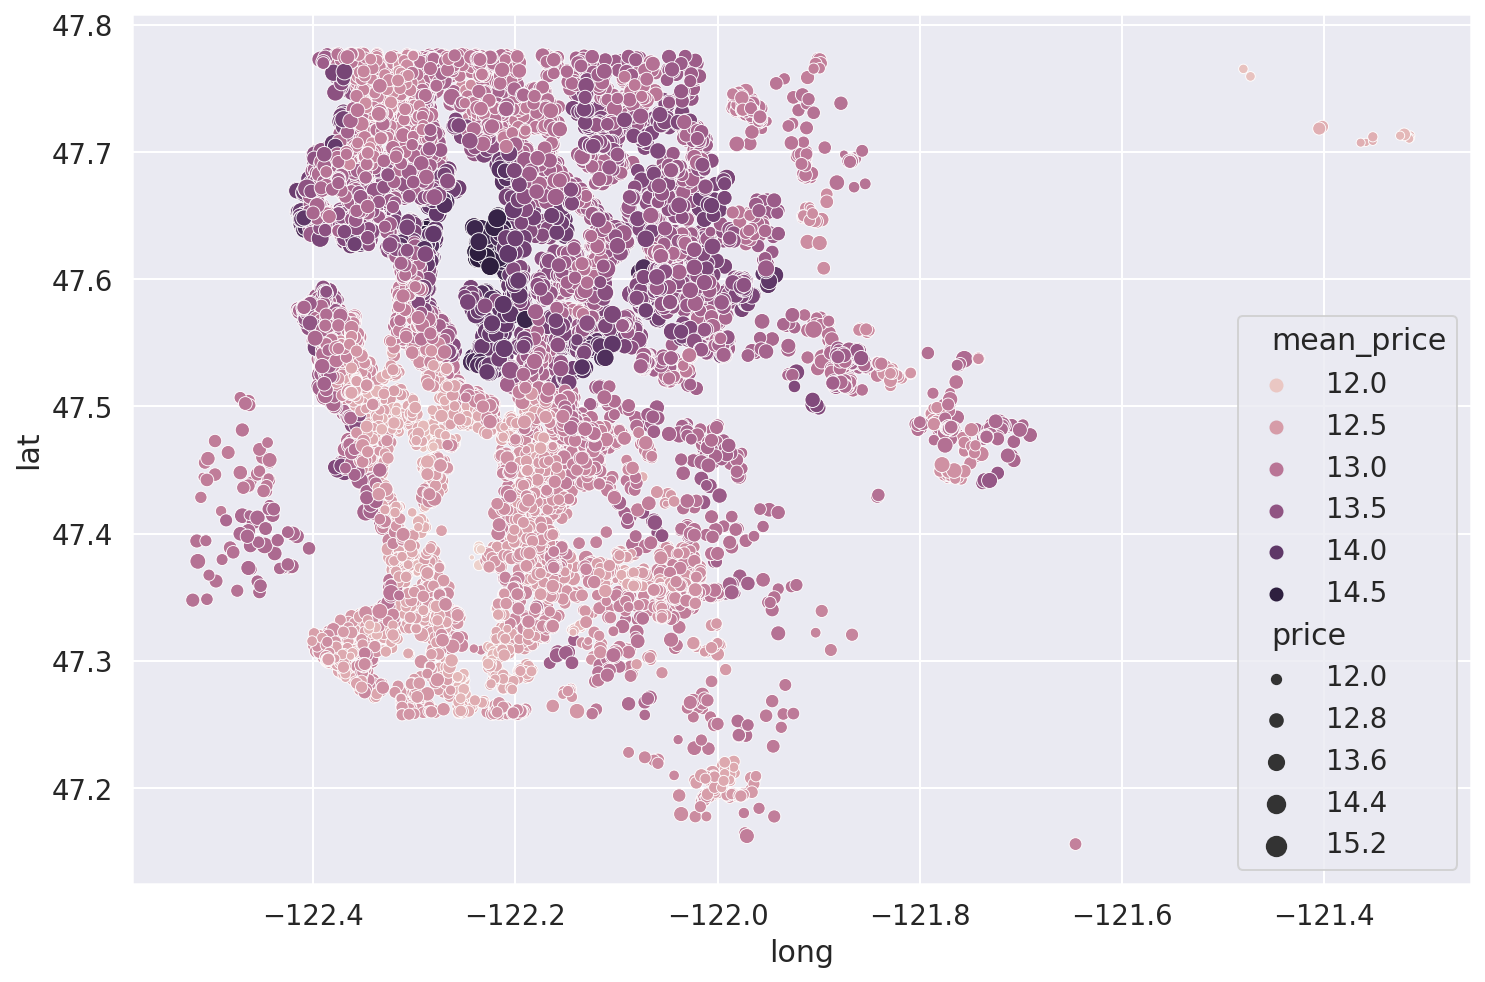

In [48]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(x='long',y='lat',hue='mean_price',size='price',sizes=(5,100), data=train)
print(train.price.corr(train.mean_price))

In [49]:
# grade + condition + view 를 합친 새로운 변수 생성
train['new_grade'] = train['grade'] + train['condition'] + train['view']
test['new_grade'] = test['grade'] + test['condition'] + test['view']

In [50]:
for df in [train, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [51]:
# target 분리
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'per_price', 'zip_level', 'mean_price', 'new_grade', 'zipcode_mean',
       'zipcode_var'],
      dtype='object')


In [52]:
# id 컬럼 삭제
sub_id = train['id']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'per_price', 'zip_level', 'mean_price', 'new_grade', 'zipcode_mean',
       'zipcode_var'],
      dtype='object')


In [53]:

# test에는 price정보가 없기 때문에 train에서 per_price col 삭제
del train['per_price']

In [54]:
# test 데이터 처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zip_level', 'mean_price', 'new_grade', 'zipcode_mean', 'zipcode_var'],
      dtype='object')


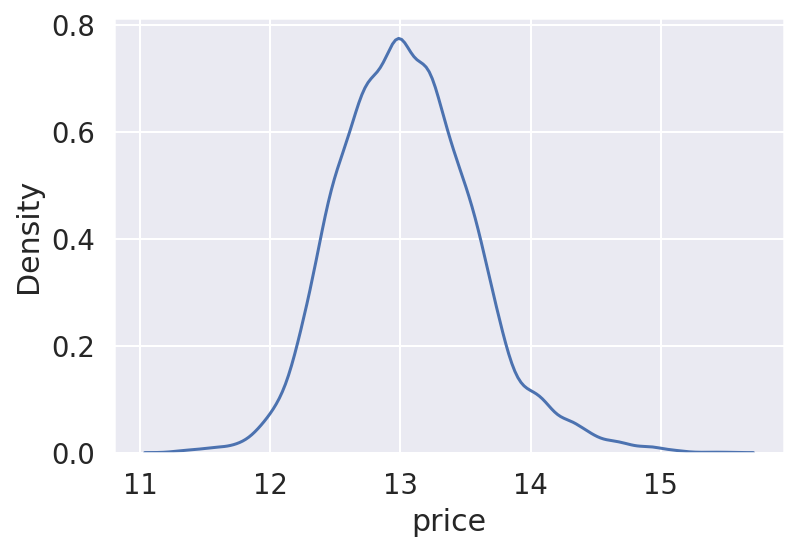

In [55]:
# y분포 확인
sns.kdeplot(y)
plt.show()

In [56]:
# train 전체 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15015 entries, 0 to 15014
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15015 non-null  int64  
 1   bedrooms         15015 non-null  int64  
 2   bathrooms        15015 non-null  float64
 3   sqft_living      15015 non-null  float64
 4   sqft_lot         15015 non-null  float64
 5   floors           15015 non-null  float64
 6   waterfront       15015 non-null  int64  
 7   view             15015 non-null  int64  
 8   condition        15015 non-null  int64  
 9   grade            15015 non-null  int64  
 10  sqft_above       15015 non-null  float64
 11  sqft_basement    15015 non-null  float64
 12  yr_built         15015 non-null  int64  
 13  yr_renovated     15015 non-null  float64
 14  zipcode          15015 non-null  int64  
 15  lat              15015 non-null  float64
 16  long             15015 non-null  float64
 17  sqft_living1

In [57]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zip_level,mean_price,new_grade,zipcode_mean,zipcode_var
0,201410,3,1.00,7.074117,8.639588,1.0,0,0,3,7,...,0.818803,7.074117,1.0,0.237168,0,3,12.498515,10,9.368147,1.214207
1,201502,2,1.00,6.647688,9.210440,1.0,0,0,3,6,...,0.721756,6.647688,1.0,0.337385,0,9,12.977845,9,9.257745,1.023549
2,201502,3,2.00,7.427144,8.997271,1.0,0,0,3,8,...,0.825489,7.427144,1.0,0.239904,0,14,13.263802,11,11.307711,0.826257
3,201406,3,2.25,7.447751,8.827615,2.0,0,0,3,7,...,0.843688,7.447751,1.0,0.328201,0,3,12.326522,10,10.626177,1.012780
4,201501,3,1.50,6.966967,9.181118,1.0,0,0,3,7,...,0.758837,6.966967,1.0,0.169910,0,3,12.588934,10,10.022306,1.004629


In [58]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zip_level,mean_price,new_grade,zipcode_mean,zipcode_var
0,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,7,...,0.883465,13.676905,0.574110,0.221233,1,9,12.835779,10,19.255794,2.321564
1,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,7,...,0.890086,13.772040,0.550478,0.272000,0,11,13.320923,12,18.113257,2.389816
2,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,11,...,0.745577,15.600098,0.551153,0.046699,0,14,13.798435,14,25.917920,0.737584
3,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,7,...,0.839232,13.551911,0.552315,0.219401,0,5,12.212216,10,19.759625,2.053191
4,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,7,...,0.858454,7.544861,1.000000,0.315720,0,6,12.580212,10,11.947244,0.477170


In [59]:
# 모듈 import
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [60]:
# rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [61]:
# 모델 import


In [62]:
# 스코어 계산 함수
def get_scores(models, train, y):
        df = {}

        for model in models:
            model_name = model.__class__.__name__
            X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if model_name in df:
                model_name = model_name + str(models.index(model))
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
        return (score_df)

In [63]:
# 그리드 탐색
from sklearn.model_selection import GridSearchCV

In [64]:

# GridSearch 함수 선언
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = -1 * results['score']
    results = results.sort_values(['RMSLE'])

    return results

In [65]:
# save_submission 함수 선언
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    
    prediction = model.predict(test)
    prediction = prediction
    
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = np.expm1(prediction)
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [66]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

In [68]:

# save_submission 함수 선언
def save_model(y_pred, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = np.expm1(y_pred)
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [69]:

# 탐색할 parameter 준비
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [1400, 1600, 2000],
    'max_depth': [5, 7, 9, 11, 13],
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
    #'num_leaves' : [127, 255, 511]
}

In [70]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.7min finished


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
9,goss,0.015,11,1400,-0.154706,0.154706
2,goss,0.015,5,2000,-0.154724,0.154724
31,goss,0.021,5,1600,-0.154778,0.154778
30,goss,0.021,5,1400,-0.154800,0.154800
18,goss,0.018,7,1400,-0.154801,0.154801
16,goss,0.018,5,1600,-0.154826,0.154826
10,goss,0.015,11,1600,-0.154851,0.154851
15,goss,0.018,5,1400,-0.154852,0.154852
32,goss,0.021,5,2000,-0.154865,0.154865
6,goss,0.015,9,1400,-0.154892,0.154892


In [71]:
xgboost = XGBRegressor(learning_rate=0.024, max_depth=10, n_estimators=1000, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=7, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.015, max_depth=13, n_estimators=1400, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='goss', learning_rate=0.015, max_depth=7, n_estimators=1400, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.015, max_depth=11, n_estimators=1400, random_state=random_state)

In [72]:
get_scores([xgboost, lightgbm0, lightgbm1, lightgbm2, lightgbm3], train, y)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,RMSE
XGBRegressor,104632.163798
LGBMRegressor2,103108.095274
LGBMRegressor3,103093.355435
LGBMRegressor4,102939.020171
LGBMRegressor,102733.151519


In [73]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [74]:
save_submission(lightgbm3, train, y, test, "LGBMRegressor", 102733)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
./data/submission_LGBMRegressor_RMSLE_102733.csv saved!


102733.제출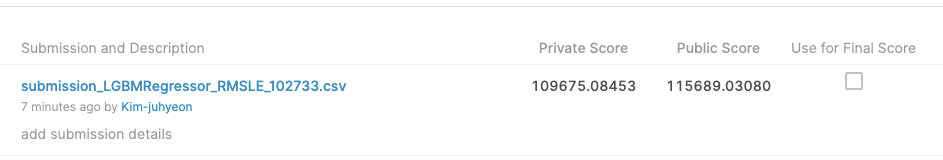

# 회고

https://github.com/ceuity/AIFFEL/blob/main/exploration_09/%5BE-09%5Dkaggle_kakr_housing.ipynb 에서 ceuity님의 코드를 참고해서 진행하였습니다. 전처리 과정에서부터 쉽지는 않았습니다. 갑자기 데이터가 load가 안된다던지, 어떤걸 이상치로 잡아서 제거를 해야할지 등등 전반적인 부분에서 쉽게쉽게 진행이 되지는 않았습니다. 특히 zipcode를 기준으로 변수들을 생성해서 좀 더 나은 데이터들의 구성으로 다시 변환시켜주었던 부분은 코드를 여러번 보았으나, 쉽게 이해가 안되는 부분이었습니다. 그래도 팀원들과의 소통으로 price와의 상관관계가 가장 높던 grade보다 더 높은 zipcode를 만들어 주어서 학습을 좀 더 효율적으로 진행이 될 수 있게 하는것이라는 걸 깨닫게 되었습니다. 또한 log 스케일을 사용해서 skewed된 부분을 고쳐야 하는것과 여러 시각화 등등 팀원들의 도움을 많이 받았습니다. 이렇게 전처리 과정을 거치고 나서 본격적인 학습 과정을 거칠수 있었습니다. 

전처리 부분은 같이 했지만, 학습에 관련해서는 팀원들끼리 각자 해보고 더 나은 결과로 통일해서 제출하자는 방향으로 진행했습니다. 제 파일에서는 한번은 xgbregressor의 모델이 성능이 좋았다가 나중에는 lgbmregressor의 성능이 더 좋아지는 현상을 발견했습니다. 다만 검색 결과 xgbregressor의 속도가 매우 느리다는 평을 보았습니다. 그래서 어느 결과가 나왔던지 간에 lgbmregressor을 사용해야 겠다는 결론을 내리고 학습을 진행하였습니다. 하이퍼파라미터의 경우는 아직 모델의 이해도가 부족해서 여러군데 github을 들락날락 하면서 조금씩 수정하는 방향으로 했습니다.

결국 최종적으로 private score기준 11만점 밑으로 내려가는 결과를 볼 수 있었고 루브릭에 충족이 되는걸 볼 수 있었습니다.

-------------------------------------

생각보다 통계를 사용해야 하는 일이 많은거 같습니다. 머신러닝의 모델이 통계를 기반으로 만들어 져서 당연히 그렇겠지만, 저에게 아직 익숙하지 않은 통계 용어나 지식들을 만나면서 계속 위축되는 저를 볼 수 있었습니다. 언젠가는 더 나은 모습일거라고 막연한 기대만 합니다 ㅎㅎ.... 이번 노드를 진행하면서 얻었던 가장 큰 성과는 물론 지식과 경험도 있지만, 팀원 혹은 다른 분들과의 활발한 소통이 있었습니다. 앞으로 남은 5개월동안 좀 막막했는데, 이번에 팀원들과의 소통으로 값진 결과를 얻게되어서 그런 걱정은 하나도 할 필요가 없을거 같다는 생각이 들었습니다.

제 자신을 돌아보자면, 나름 열심히 했는데 많이 부족한거 같습니다. 정확히 말하자면, 지식의 부족도 있지만 어떤 부분을 내가 모르고 어떤 부분을 내가 공부를 해야 하는지에 관해서 구체적인 방향을 아직 찾지 못했다는것이 제가 많이 부족하다는걸 보여주는거 같습니다. 하지만 앞서 언급했듯 막연히 언젠가는 더 나아지겠지라는 기대감과 시간의 투자가 있으면 진짜 언젠가는 더 나아지지 않을까 싶습니다. 많이 부족해도 잘 부탁드립니다!